# Bayesian Classification Using Gaussian Mixture Model and EM Estimation

This notebook is focusing on Gaussian Mixture and EM estimation. I hope it will help when reading the second capule paper.

**References**

- [Matrix Capsules With EM Routing](https://openreview.net/forum?id=HJWLfGWRb&noteId=rk5MadsMf)
- [stat315a Gaussian mixture models](http://statweb.stanford.edu/~tibs/stat315a/LECTURES/em.pdf)
- [brilliant.org wiki gaussian-mixture-model](https://brilliant.org/wiki/gaussian-mixture-model/#targetText=Gaussian%20mixture%20models%20are%20a,subpopulations%20within%20an%20overall%20population.&targetText=Estimating%20the%20parameters%20of%20the,in%20modeling%20data%20with%20GMMs.)
- [Wiki Multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)
- [Wiki Expectation maximization algorithm](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import itertools
import time

## Generate random dots

If the dots are not you wanted, you can run this cell multiple times.

In [2]:
NUM_CLASSES = 4
NUM_DIMENSION = 2

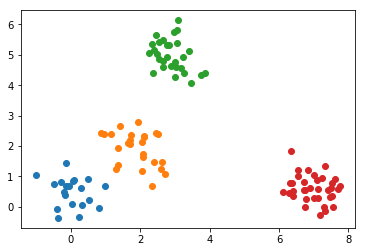

In [4]:
%matplotlib inline
randLocal = lambda c: np.random.rand()*(c+1)*2

thedots = [
    np.random.normal(
        loc=(randLocal(c), randLocal(c)), 
        scale=0.5, 
        size=(np.random.randint(20,50),2)
    )
    for c in range(NUM_CLASSES)
]

for d in thedots:
    plt.plot(d[:,0], d[:,1], 'o')
plt.show()

generateddots = np.concatenate(thedots)
np.random.shuffle(generateddots) # only suffle the first dimension

## Build and Learn the model - Gaussian mixture model (GMM)

Let $X = \{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_I\}$ as $I$ **independent** datapoints, and $C = \{\mathbf{c}_1, \mathbf{c}_2, \ldots, \mathbf{c}_J\}$ as $J$ clusters with dimension $d$. The pobility of datapoint $\mathbf{x}_i$ match to cluster $c_j$ is $p(\mathbf{c}_j) = \phi_{j}$, $\sum_j \phi_{j} = 1$.

The aim is to estimate the unknown parameters representing the mixing value between the Gaussians and the means and covariances of each:

$$\theta = \left( \phi_{j}, \boldsymbol{\mu}_j, \Sigma_j \right)$$

where $\mu_j$ are custer centers and $\Sigma_j$ are covariance matrixes.

The likelihood $L(\theta; X,C) = p(X,C | \theta)$.

$$
\arg \max_{\theta} L(\theta; X,C) \Leftrightarrow \arg \max_{\theta} \log L(\theta; X, C)
$$

$$
\begin{aligned}
\log L(\theta; X,C) &= \log p(X,C | \theta)\\
&= \log \prod_{i,j}^{I,J} \phi_{j} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_j, \Sigma_j) \\
&= \log \prod_{i,j}^{I,J} \phi_{j} \dfrac{1}{\sqrt{(2 \pi)^d |\Sigma_j|}} \exp\left(
        - \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_j)^T \Sigma_j^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_j)
    \right)\\
&= \sum_{i,j}^{I,J}
    \log\left(
        \phi_{j} \dfrac{1}{\sqrt{(2 \pi)^d |\Sigma_j|}} \exp\left(
        - \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_j)^T \Sigma_j^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_j)
    \right)
\right)\\
&= \sum_{i,j}^{I,J} \left(
    \log\phi_{j} 
    - \frac{d}{2} \log 2 \pi
    - \frac{1}{2} \log |\Sigma_j|
    - \frac{1}{2}
         (\mathbf{x}_i - \boldsymbol{\mu}_j)^T \Sigma_j^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_j)
    \right)\\
\end{aligned}
$$

In [5]:
def gaussianpdf(X, Mu, Sigma):
    """
    Require:
        X: (I,N)
        Mu: (J,N)
        Sigma: (J,N,N)
    Return:
        N(x; mu, sigma): (I,J)
    """
    sI, sN = X.shape
    sJ, sN = Mu.shape
    
    isigma = np.linalg.inv(Sigma) # jnm
    detsigma = np.linalg.det(Sigma) # j
    
    dscale = 1 / np.sqrt(((2 * np.pi)**sN) * detsigma) # j
    xSmu = np.zeros((sI, sJ))
    for (i,xi), (j,muj), isj in itertools.product(enumerate(X), enumerate(Mu), isigma):
        xiEmuj = xi - muj
        xSmu[i,j] = -0.5 * xiEmuj.T @ isj @ xiEmuj

    gauss = dscale * np.exp(xSmu)
    return gauss

### E-Step

Given our current estimate parameters $\theta^{(t)}$, the conditional distribution of the $c_j$ is determined by Bayes theorem:

$$
p(C| X, \theta^{(t)})
= \dfrac{
    p(\mathbf{x}_i, \theta^{(t)} | \mathbf{c}_j) p(\mathbf{c}_j)
}{
    \sum_k^J p(\mathbf{x}_i, \theta^{(t)} | \mathbf{c}_k) p(\mathbf{c}_k)
}
= \dfrac{
    \phi_{j} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_j, \Sigma_j)
}{
    \sum_k^{J} \phi_{k} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_k, \Sigma_k)
}
\equiv T_{ij}^{(t)}
$$

Obviously, $\sum_j T_{ij}^{(t)} = 1$, $\sum_{ij} T_{ij}^{(t)} = J$.

The expection is 

$$
\mathbb{E}_{C|X, \theta^{(t)}} [\log L(\theta; X, C)]
= \sum_{i,j}^{I,J} T_{ij}^{(t)} \left(
    \log\phi_{j}
    - \frac{d}{2} \log 2 \pi
    - \frac{1}{2} \log |\Sigma_j|
    - \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_j)^T \Sigma_j^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_j)
\right)
$$

In [6]:
# compute T
def computeT(phi, X, Mu, Sigma):
    """
    Require:
        phi: (J)
        X: (I,N)
        Mu: (J,N)
        Sigma: (J,N,N)
    Return:
        T: (I,J)
    """
    gauss = gaussianpdf(X, Mu, Sigma)
    theT = phi[None,:] * gauss
    theT = theT / np.sum(theT, 1, keepdims=True)
    return theT

### M-Step

#### Estimate $\phi_{j}$

$$
\begin{aligned}
    \phi_{j}^{(t+1)} 
    &= \arg\max\limits_{\phi_{j}} \mathbb{E}_{C|X, \theta^{(t)}} [\log L(\theta; X, C)]\\
    &\Rightarrow \arg\min\limits_{\phi_{j}} \sum_{i,j}^{I,J} - T_{ij}^{(t)} \log \phi_{j}\\
    &\qquad \text{s.t.} \sum_j \phi_j = 1
\end{aligned}
$$

Lagrange method:

$$
\mathcal{L}(\phi_j, \lambda) = - T_{ij}^{(t)} \log \phi_j - \lambda (1 - \sum_j \phi_j)
$$

Please notice that $T_{ij}^{(t)}$ here is come from E-step, there it is **not** a function of $\phi_j$. We take the partial derivatives and set them to zero. 

$$
\begin{aligned}
    \dfrac{\partial \mathcal{L}}{\partial \phi_j} 
    &= - \dfrac{1}{\phi_j} \sum_{i} T_{ij}^{(t)} + \lambda \equiv 0\\
    \dfrac{\partial \mathcal{L}}{\partial \lambda} 
    &= 1 - \sum_j \phi_j \equiv 0
\end{aligned}
$$

Therefore, we have:

$$
\lambda \phi_j = \sum_i T_{ij}^{(t)} 
\leftrightarrow 
\sum_j \lambda \phi_j = \sum_{ij} T_{ij}^{(t)} 
\leftrightarrow
\lambda = J
$$
$$
\phi_j^{t+1} = \dfrac{1}{J} \sum_{i} T_{ij}^{(t)} 
$$

#### Estimate $\mu_{j}$

$$
\begin{aligned}
    \mu_{j}^{(t+1)} 
    &= \arg\max\limits_{\mu_{j}} \mathbb{E}_{C|X, \theta^{(t)}} [\log L(\theta; X, C)]\\
    &\Rightarrow \arg\min\limits_{\mu_{j}} \sum_i T_{ij}^{(t)}
        (\mathbf{x}_i - \boldsymbol{\mu}_j)^T \Sigma_j^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_j)
\end{aligned}
$$

Let $g(\mu_j) = \sum_i T_{ij}^{(t)} (\mathbf{x}_i - \boldsymbol{\mu}_j)^T \Sigma_j^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_j)$, take the derivative of $g$ with respect to $\mu_j$ is

$$
\dfrac{\partial g}{\partial \mu_j} 
= -2 \sum_{i} T_{ij}^{(t)} \Sigma_{j}^{-1} (x_i - \mu_j) = 0
$$

Thefore, the minimum $\mu_j$ is

$$\mu_j = \dfrac{\sum_i T_{ij}^{(t)} x_i}{\sum_i T_{ij}^{(t)}}$$

#### Estimate $\Sigma_{j}$

$$
\begin{aligned}
    \Sigma_j^{(t+1)} 
    &= \arg\max\limits_{\Sigma_j} \mathbb{E}_{C|X, \theta^{(t)}} [\log L(\theta; X, C)]\\
    &\Rightarrow \arg\min\limits_{\Sigma_j} \sum_{i}^{I} T_{ij}^{(t)} \left(
        \log |\Sigma_j| + 
        (\mathbf{x}_i - \boldsymbol{\mu}_j)^T \Sigma_j^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_j)
\right)
\end{aligned}
$$

Let $g(\Sigma_j) = \sum_{i}^{I} T_{ij}^{(t)} \left( \log |\Sigma_j| + (\mathbf{x}_i - \boldsymbol{\mu}_j)^T \Sigma_j^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_j) \right)$, and take the partial derivative of it, we have

$$
\dfrac{\partial g}{\partial \Sigma_j}
= \sum_i T_{ij}^{(t)} \left(
    \Sigma_j^{-T}
    - \left(
        (\mathbf{x}_i -  \boldsymbol{\mu}_j)
        \Sigma_j^{-1}
    \right)^T 
    \left(
      (\mathbf{x}_i - \boldsymbol{\mu}_j) \Sigma_j^{-1}
    \right)
\right)
= 0
$$

Therefore, we have

$$
\Sigma_j^{(t+1)} = 
\dfrac{
    \sum_i T_{ij}^{(t)} 
    (\mathbf{x}_i -  \boldsymbol{\mu}_j)^T
    (\mathbf{x}_i - \boldsymbol{\mu}_j)
}{
    \sum_i T_{ij}^{(t)}
}
$$



#### Summize

1. E-step

$$
T_{ij}^{(t)} = \dfrac{
    \phi_{j} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_j, \Sigma_j)
}{
    \sum_k^{J} \phi_{k} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_k, \Sigma_k)
}
$$

2. M-Step

$$
\begin{aligned}
    \phi_j^{t+1} 
    &= \dfrac{1}{J} \sum_{i} T_{ij}^{(t)}\\
    \mu_j^{(t+1)}
    &= \dfrac{\sum_i T_{ij}^{(t)} x_i}{\sum_i T_{ij}^{(t)}}\\
    \Sigma_j^{(t+1)} 
    &= \dfrac{
        \sum_i T_{ij}^{(t)}
        (\mathbf{x}_i -  \boldsymbol{\mu}_j)^T
        (\mathbf{x}_i - \boldsymbol{\mu}_j)
    }{
        \sum_i T_{ij}^{(t)}
    }
\end{aligned}
$$

In [7]:
def estimatePhiMuSigma(T, X, Mu):
    """
    Require:
        T: (I,J)
        X: (I,N)
        Mu: (J,N)
    Return:
        Phi: (J)
        Mu: (J, N)
        Sigma: (J, N, N)
    """
    sJ, sN = Mu.shape
    
    tsumi = np.sum(T, axis=0) # \sum_i T_{ij}
    phi = tsumi / sJ
    mu = np.matmul(X.T, T) / tsumi
    mu = mu.T
    sigma = np.zeros((sJ, sN, sN))
    for (j,muj), tj in zip(enumerate(Mu), T.T):
        xiEmuj = X - muj # I,N
        # tj (I,)
        sigma[j] = np.matmul(xiEmuj.T, tj[:,None] * xiEmuj)
    sigma = sigma / tsumi[:,None,None]
    return phi, mu, sigma

Take random $\phi_{j}$ and make sure $\sum_j \phi_j = 1$

Take random $\boldsymbol{\mu}_j$ and $\Sigma_j$.

In [8]:
%matplotlib notebook

In [19]:
rPhi = np.random.rand(NUM_CLASSES)
rPhi = rPhi / np.sum(rPhi)

# rMu = np.random.randn(NUM_CLASSES, NUM_DIMENSION)
mumask = np.random.randint(0,len(generateddots), NUM_CLASSES)
rMu = generateddots[mumask]
rSigma = np.random.randn(NUM_CLASSES, NUM_DIMENSION, NUM_DIMENSION)
rSigma = np.matmul(np.swapaxes(rSigma, -2, -1), rSigma)

<IPython.core.display.Javascript object>


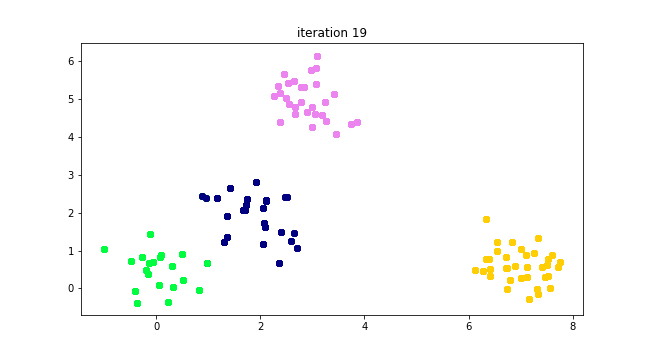

<IPython.core.display.Javascript object>


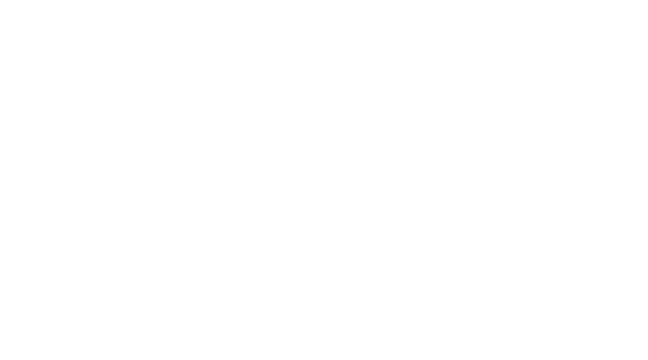

In [20]:
fig = plt.figure(figsize=(9,5))
plt.show()

plt.gca().set_prop_cycle(
    color=[plt.cm.gist_ncar(i) for i in np.linspace(0,0.9,NUM_CLASSES)]
)

Told = np.random.rand(len(generateddots), NUM_CLASSES)

for i in range(50):
    time.sleep(0.5)
    
    T = computeT(rPhi, generateddots, rMu, rSigma)
    
    if np.linalg.norm(Told - T) < 2e-2:
        break
    Told = T
    
    rPhi, rMu, rSigma = estimatePhiMuSigma(T, generateddots, rMu)

    Tmax = np.argmax(T, 1)

    for ccenter in range(NUM_CLASSES):
        selectedx = generateddots[Tmax == ccenter]
        plt.plot(selectedx[:,0], selectedx[:,1], 'o')
    plt.title(f"iteration {i}")
    fig.canvas.draw()
    